In [163]:
import numpy as np 
import csv 
import pandas as pd
from scipy.linalg import dft
from scipy import fft
from scipy import ifft
import matplotlib.pyplot as plt 
import bitarray
import pdb
from scipy.io.wavfile import write # For writing to a .wav file
from scipy.io.wavfile import read # For reading from a .wav file to an np array.
from scipy import signal # Module for generating chirp.

In [187]:
# Define constants
N = 1024 #OFDM symbol length
L = 400 #Cyclic prefix length
n = 50 # Number of repetitions of OFDM symbol for transmission
sample_rate = 44100 # Sample rate is 44.1 kHz
chirp_duration = 1
pilot_value = 1+1j # The known value each pilot transmits
FILE_NAME = "generated_transmitted_signal.wav" #name of the file in which we save the pseudo transmitted wave 
pilot_FILE_NAME = 'pilot_' + FILE_NAME
A = 100 #radius of QPSK symbols
chirp_startFrequency = 0
chirp_endFrequency = 10000 

In [188]:
# Useful helper functions for converting between np arrays and wav files.
def convert_array_to_wav(array, sample_rate, FILE_NAME):
    # Convert the normalized array to a wav file.
    write(FILE_NAME, sample_rate, array)

def convert_wav_to_array(wav_filename):
    rate, array = read(wav_filename)

    return array

## Transmitter - transmitted signal has chirp and block of known OFDM symbols 

In [189]:
# Functions mainly for use in transmitter.

# Generate chirp signal
def generateChirp(startFrequency, endFrequency, sample_rate, duration):
    number_of_samples = int(sample_rate*duration)
    t = list(range(0, number_of_samples+1))
    t = np.array(t)
    t = t / sample_rate
    chirp = signal.chirp(t, startFrequency, duration, endFrequency, method='linear')

    return chirp

# Matched filter returns index of highest correlation between a noisy signal and the desired signal.
def matched_filter(noisy_signal, desired_signal):
    desired_signal = desired_signal.flatten()
    
    correlation = signal.correlate(noisy_signal, desired_signal, mode='same')
    x = np.arange(len(correlation))
    
    fig, ax = plt.subplots()
    plt.title("Matched filtering")
    plt.xlabel("Sample")
    plt.ylabel("Correlation between chirp and noisy received signal - amplitude")

    ax.plot(x, correlation)
    fig.show()
    
    
    
    max_correlation = np.amax(correlation)
    max_correlation_index = np.argmax(correlation)

    return max_correlation_index

def find_chirp_start_index(chirp_signal):
    """Uses matched filter to find index of start of chirp"""
    chirp_length = len(chirp_signal)
    chirp_start_index = matched_filter(chirp_signal, chirp_signal)
    assert chirp_start_index == int(chirp_length/2), "Chirp start index does not coincide with half of chirp length"
    return chirp_start_index

# Need to fix this, block size gives error with large integer
def generate_random_indices(block_size):
    """Generates numpy array of random indices with seed '2021' such that random array is predictable"""
    seed = 2021 # Standardise random number generator seed as 2021, which I arbitrarily selected
    rng = np.random.default_rng(seed) # Random number generator with specified seed
    random_constellation_indices = rng.integers(low=0, high=4, size=block_size) # Generate 511 random indices for the QPSK constellation

    return random_constellation_indices

# Generate an array of 511 random constellation symbols with '0' as the first element.
# 'A' is the radius of the QPSK constellation circle.

def generate_random_sequence(N, QPSK=True):
    """Takes the size of OFDM symbol length, assuming QPSK encoding and returns array of random constellation symbols"""
    block_size = int(N / 2 - 1) # Set size of block to OFDM symbol length divided by 2 for mirroring and subtract 1 to have zeroed first entry
    mapping = A/np.sqrt(2) * np.array([(1+1j), (-1+1j), (-1-1j), (1-1j)]) # Define the mapping of indices to QPSK constellation
    
    random_constellation_indices = generate_random_indices(block_size)
    random_sequence = np.array([0]) # Set up first element to be constellation symbol corresponding to zero
    for index in random_constellation_indices:
        random_sequence = np.append(random_sequence, mapping[index])

    return random_sequence
  
# Takes an array and appends the flipped/reversed complex-conjugate array. The two concatenated arrays both begin with a '0'.
def generate_symmetric_sequence(sequence):
    """Takes a array sequence and appends a reversed form on the end"""
    reversed_sequence = np.conj(np.append(np.array([0]), np.flip(sequence[1:int(N/2)]))) # Reverse the order of the input array, and take the complex conjugate.
    symmetric_sequence = np.append(sequence, reversed_sequence) # Append the flipped array to the original array.
    return symmetric_sequence

# Take N-point iDFT of an array, to be used carefully! This function should probably be named differently!!!
def apply_inverse_dft(sequence):
    """Takes a N-point inverse discrete Fourier transform of a sequence, who's output is purely real"""
    OFDM_TX_noCP = ifft(sequence) # Take inverse discrete Fourier transform
    assert np.amax(OFDM_TX_noCP.imag) < 1, "Input sequence in frequencey domain is not symmetric so time domain is not purely real"

    OFDM_TX_noCP = OFDM_TX_noCP.real # Consider only real part given that it is supposed to be real
    return OFDM_TX_noCP

# Add cyclic prefix
def add_cyclic_prefix(sequence, N, L):
    """Takes sequence, the symbol length and cyclic prefix length L to insert cyclic prefix"""
    cyclic_prefix = sequence[-L:] # Generate cyclic prefix by taking last values
    OFDM_TX_withCP = np.append(cyclic_prefix, sequence) # Create single OFDM symbol by joining cyclic prefix and sequence
    return OFDM_TX_withCP

# Create the array to be transmitted by repeating the above OFDM symbol some number of times. (And including any elements needed for synchronization).
def generate_repeated_signal(OFDM_TX_withCP, n):
    """Generate signal to be transmitted by repeating the OFDM symbol n times"""
    repeated_signal = np.array([]) # Repeats OFDM symbol n times
    for i in range(0,n):
        repeated_signal = np.append(repeated_signal, OFDM_TX_withCP)
    return repeated_signal

def generate_signal_for_estimation(N, n, FILE_NAME, use_chirp=True):
    """The 'master' function that takes the block length N"""
    
    # (In time domain)
    if use_chirp:
        chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration) # Generate chirp signal for start of transmission
    
    # (In frequency domain)
    random_sequence = generate_random_sequence(N) # Generate random but predictable seqeunce which (length N/2)
    symmetric_sequence = generate_symmetric_sequence(random_sequence) # Create symmetric sequence to make transmitted OFDM symbol real (length N)

    # (In time domain)
    OFDM_TX_noCP = apply_inverse_dft(symmetric_sequence) # Apply the inverse DFT to generate time_domain OFDM symbol without cyclic prefix (length N)
    OFDM_TX_withCP = add_cyclic_prefix(OFDM_TX_noCP, N, L) # Insert cyclic prefix to create OFDM symbol (length N+L)
    repeated_signal = generate_repeated_signal(OFDM_TX_withCP, n) # Repeat OFDM symbol n times (length n*(N+L))
    transmitted_signal = np.append(chirp_signal, repeated_signal) # Create transmitted signal by inserting chirp at start (length chirp_length n*(N+L))
    
    # Plot the transmitted signal
    t = list(range(1, len(transmitted_signal)+1))
    times = np.array(t)
    #times = times / sample_rate
    x = times
    fig, ax = plt.subplots()
    plt.title("Transmitted Signal")
    plt.xlabel("Sample")
    plt.ylabel("Transmitted Signal Magnitude")
    plt.axvline(x=0) #Should be at beginning of chirp
    plt.axvline(x=22050) #Should be at end of chirp
    # plt.xlim(0, 1000)
    plt.ylim(-1.1, 1.1)
    ax.plot(x, transmitted_signal)
    fig.show()
    
    convert_array_to_wav(transmitted_signal, sample_rate, FILE_NAME)

    return transmitted_signal


## Receiver - received signal has chirp and block of known OFDM symbols

In [190]:
# Functions mainly for use in receiver.

# Calculates the delay present at the receiver in terms of indices in the arrays
# by applying the matched filter to the received signal.

def calculate_delay_at_receiver(received_signal, chirp_signal):
    """Takes the received signal and the chirp, then calculates the 'time' delay at the receiver"""
    correlation_max_index = matched_filter(received_signal, chirp_signal) # Find start of actual information being transmitted
    chirp_start_index = find_chirp_start_index(chirp_signal) # Find start of chirp
    delay = correlation_max_index - chirp_start_index # Find difference between the two as the delay

    return delay

# Shift the received array left by the amount of the delay. (A certain number of elements) Also cut the array where we expect the transmitted sequency to end.
def calculate_received_signal_without_delay(received_signal, chirp_signal):
    """Takes the received signal and the chirp, to remove the delay and perform synchronisation"""
    delay = calculate_delay_at_receiver(received_signal, chirp_signal) # Calculate delay

    chirp_length = len(chirp_signal) # Find length of chirp signal
    received_signal_without_delay = received_signal[delay+chirp_length:delay+chirp_length+(n*(N+L))] # Using calculated delay, remove the delay

    return received_signal_without_delay

# Remove cyclic prefix
def removeCP(signal):
    """Remove the cyclic prefix of a signal"""
    # to do: adjust for the whole signal, not just one ofdm block
    return signal[L:(L+N)]

def DFT(OFDM_RX):
    """Compute the discrete Fourier transform of the received OFDM symbol"""
    return fft(OFDM_RX)

def compute_average(two_dimensional_array, N, n):
    """
    Computes the average of a two-dimensional array, element-wise.
    Needs the length of the 'block' N and the number of blocks n.
    For example, inputting np.array([[0,1,2],[2,3,4]]) would return np.array([1,2,3]).
    Note, we call each individual array a 'block' so we are just averaging over them.
    (There should be a nicer 'numpyier' 'vectorised' way of doing this better, try later)
    """
    sum_of_blocks = np.zeros(N) # Initialise as zeros array for summing each block of two-dimensional array
    for block in two_dimensional_array:
        sum_of_blocks = sum_of_blocks + block # Compute sum of each block all together
    average_block = sum_of_blocks / n # Take average by dividing by number of blocks
    return average_block

def compute_average_symbol(received_signal):
    """Takes the received signal without delay, computes the average received OFDM symbol without cyclic prefix, then takes DFT to return in frequency domain"""
    # (In time domain)
    received_signal = np.split(received_signal, n) # Split up received signal into blocks
    OFDM_RX_noCP = [removeCP(received_block) for received_block in received_signal] # Remove cyclic prefix
    OFDM_RX_noCP_average = compute_average(OFDM_RX_noCP, N, n) # Computes the average received block without cyclic prefix
    
    # Note that beyond this point, we are dealing with an 'averaged' block in the time domain because of previous step
    
    # (In frequency domain)
    OFDM_RX_demod_average = DFT(OFDM_RX_noCP_average) # Compute DFT of received signal without cyclic prefix
    
    return OFDM_RX_demod_average

def estimate_channel_frequency_response(OFDM_RX_demod_average, transmitted_block): #transmitted block is known from before
    """
    Takes the demodulated received OFDM sequence and the initially transmitted block.
    Estimates the channel frequency response by division.
    """
    
    # (In frequency domain)
    # Some checks which can be removed later
    #print(np.shape(OFDM_RX_demod_average[1:int(N/2)])) # Only take first postiive 'real' half and ignore zero at start
    #print(np.shape(transmitted_block[1:])) # Ignore first value which is zero to avoid dividing by zero

    H_est = OFDM_RX_demod_average[1:int(N/2)] / transmitted_block[1:] # divide second half of averaged demodulated block by the transmitted pilot values
    #print(np.shape(H_est))
    #H_est_abs = abs(H_est) # Compute amplitude of frequency response
    #H_est_phase = np.angle(H_est) # Compute amplitude of frequency response
    return H_est


def compute_channel_impulse_response(H_est):
    # (In frequency domain)
    H_est_symmetric = generate_symmetric_sequence(H_est)
    
    # (In time domain)
    h_time = apply_inverse_dft(H_est_symmetric)
    return h_time

def estimate_channel(input_audio_filename):
    """
    'Master' function to estimate the channel impulse response in time domain
    """
    # (In time domain)
    received_signal = convert_wav_to_array(input_audio_filename) # Convert received .wav file to an np array.
    #seed = 2021
    #rng = np.random.default_rng(seed)
    #received_signal = np.append(rng.random(100), received_signal)
    chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
    received_signal_without_delay = calculate_received_signal_without_delay(received_signal, chirp_signal) # Perform synchronisation by removing time delay
    print(received_signal_without_delay)
    # (In frequency domain)
    OFDM_RX_demod_average = compute_average_symbol(received_signal_without_delay) # Compute the average demodulated OFDM sequence
    H_est = estimate_channel_frequency_response(OFDM_RX_demod_average, generate_random_sequence(N)) # Be careful that random sequence is the same from earlier

    # (In time domain)
    h_time = compute_channel_impulse_response(H_est) #
    return h_time, H_est


## Synchronization 

42562


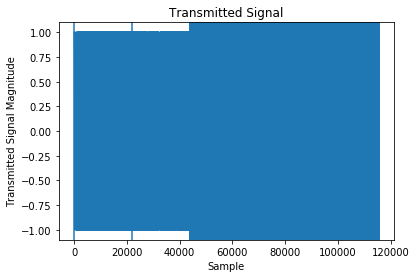

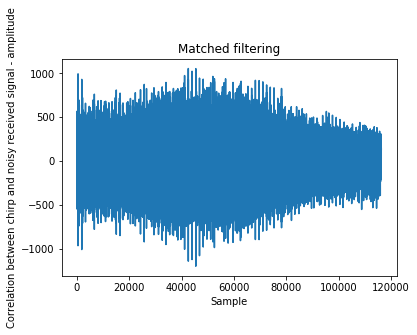

In [194]:
# Transmitter
# Create the transmitted OFDM_signal and output to .wav file
#Transmitted signal + delay + white noise 
transmitted_signal = generate_signal_for_estimation(N, n, FILE_NAME)
transmitted_signal = np.append(np.zeros(1000), transmitted_signal)
white_noise = np.random.normal(0, 1, len(transmitted_signal))
transmitted_signal = transmitted_signal + white_noise


convert_array_to_wav(transmitted_signal, sample_rate, 'input.wav')



channelResponse = pd.read_csv('channel.csv')
zero_array = np.zeros(len(transmitted_signal) - len(channelResponse))
channelResponse = np.append(channelResponse, zero_array)

receiver_signal = signal.convolve(channelResponse, transmitted_signal, mode='same')



def matched_filter(noisy_signal, desired_signal):
    desired_signal = desired_signal.flatten()
    
    correlation = signal.correlate(noisy_signal, desired_signal, mode='same')
    x = np.arange(len(correlation))
    
    fig, ax = plt.subplots()
    plt.title("Matched filtering")
    plt.xlabel("Sample")
    plt.ylabel("Correlation between chirp and noisy received signal - amplitude")
    #plt.xlim(75152 - 100, 75152 + 100)
    ax.plot(x, correlation)
    fig.show()
    
    
    
    max_correlation = np.amax(correlation)
    max_correlation_index = np.argmax(correlation)

    return max_correlation_index

chirp = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
ind = matched_filter(receiver_signal, chirp_signal)
print(ind)

In [ ]:
# Plot the receiver signal with noise and delay 
t = list(range(1, len(receiver_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Received Signal With Noise and Delay")
plt.xlabel("Sample")
plt.ylabel("Received Signal Magnitude")
#plt.axvline(x=0) #Should be at beginning of chirp
#plt.axvline(x=22050) #Should be at end of chirp
plt.xlim(0, 3000)
#plt.ylim(-1.1, 1.1)
ax.plot(x, receiver_signal)
fig.show()

# Plot the transmitted signal with noise and delay 
t = list(range(1, len(transmitted_signal)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Transmitted Signal With Noise and Delay")
plt.xlabel("Sample")
plt.ylabel("Transmitted Signal Magnitude")
#plt.axvline(x=0) #Should be at beginning of chirp
#plt.axvline(x=22050) #Should be at end of chirp
plt.xlim(0, 3000)
#plt.ylim(-1.1, 1.1)
ax.plot(x, transmitted_signal)
fig.show()


145348
75152


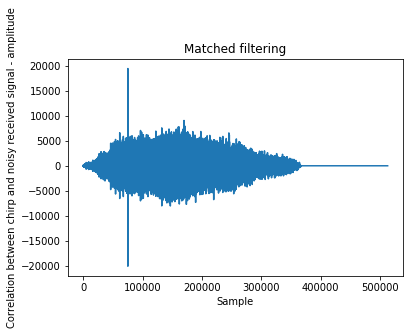

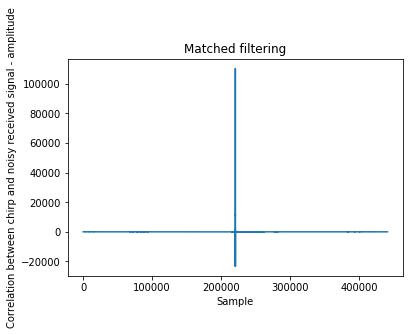

In [182]:
chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, chirp_duration)
ind = matched_filter(receiver_signal, chirp_signal) 
ind2 = matched_filter(chirp_signal, chirp_signal)
print(ind2 - ind)
print(ind)

220501
220501
110250
110250


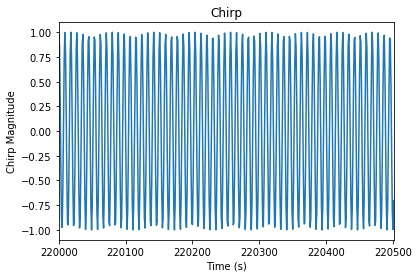

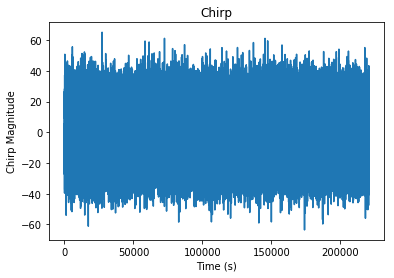

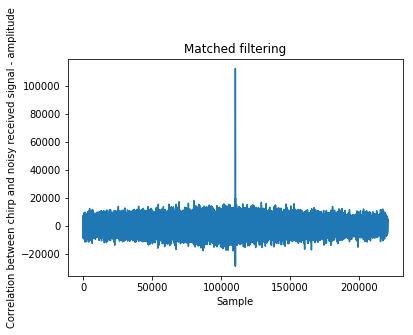

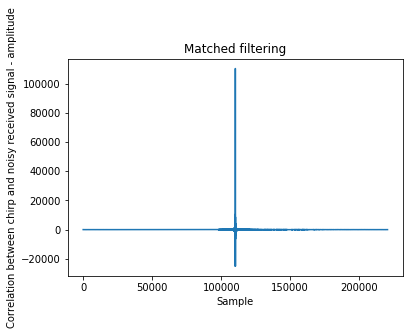

In [158]:
chirp_signal = generateChirp(chirp_startFrequency, chirp_endFrequency, sample_rate, 5)
white_noise = np.random.normal(0, 14, len(chirp_signal))
chirp_signal_noise = chirp_signal + white_noise 


t = list(range(1, len(chirp_signal)+1))
print(len(chirp_signal))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Chirp")
plt.xlabel("Time (s)")
plt.ylabel("Chirp Magnitude")
ax.plot(x, chirp_signal)
plt.xlim(220000, 220501)
fig.show()


t = list(range(1, len(chirp_signal_noise)+1))
print(len(chirp_signal_noise))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Chirp")
plt.xlabel("Time (s)")
plt.ylabel("Chirp Magnitude")
ax.plot(x, chirp_signal_noise)
fig.show()

max_corr_index = matched_filter(chirp_signal_noise, chirp_signal)
print(max_corr_index)
print(find_chirp_start_index(chirp_signal))

In [32]:
# Receiver

# Estimate channel from input audio file.
h_est, H_est = estimate_channel('input.wav')

h_est = h_est[:100]
t = list(range(1, len(h_est)+1))
times = np.array(t)
#times = times / sample_rate
x = times
fig, ax = plt.subplots()
plt.title("Estimated Channel Impulse Response")
plt.xlabel("Time (s)")
plt.ylabel("Impulse Response Magnitude")
ax.plot(x, h_est)
fig.show()

f = list(range(1, len(H_est)+1))
frequencies = np.array(f)
#frequencies = (sample_rate / N) * frequencies
x = frequencies
fig, ax = plt.subplots()
plt.title('Magnitude of DFT of Channel Impulse Response estimated using repeated random OFDM symbols')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative Amplitude')
plt.yscale('log')
ax.plot(x, abs(H_est))
fig.show()


ValueError: array split does not result in an equal division

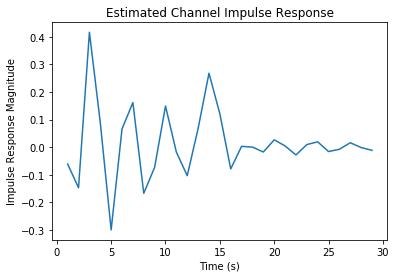

In [64]:
channel_response = pd.read_csv('channel.csv')
t = list(range(1, len(channel_response)+1))
times = np.array(t)
x = times
fig, ax = plt.subplots()
plt.title("Estimated Channel Impulse Response")
plt.xlabel("Time (s)")
plt.ylabel("Impulse Response Magnitude")
ax.plot(x, channel_response)
fig.show()

#### Pilot tones channel synchronization 

In [87]:
all_carriers = np.arange(N)  # indices of all subcarriers ([0, 1, ... N-1])

pilot_carriers = all_carriers[::N//L] # Pilots is every (N/L)th carrier.

# for convenience of channel estimation, make the last carriers also be a pilot
pilot_carriers = np.hstack([pilot_carriers, np.array([all_carriers[-1]])])
L = L + 1 
# data carriers are all remaining carriers
data_carriers = np.delete(all_carriers, pilot_carriers)


# Defining new functions based on chirp synch 

def pilot_generate_random_sequence(N, L, QPSK = True):
    """Takes the size of OFDM symbol length, assuming QPSK encoding 
    and returns array of random constellation symbols, but placing the known QPSK symbol on every n_pilot-th place"""
    
    block_size = int(N/2 - 1) 
    QPSK_indices = generate_random_indices(block_size) 
    mapping = A/np.sqrt(2) * np.array([(1+1j), (-1+1j), (-1-1j), (1-1j)])
    
    random_sequence = np.array([0])
    n_pilot = N//L 
    for index in QPSK_indices:
        if index % n_pilot == 0:
            random_sequence = np.append(random_sequence, A*pilot_value) # setting a known pilot value on the pilot_place 
        else:
            random_sequence = np.append(random_sequence, mapping[index])
    return random_sequence   

def pilot_generate_symmetric_sequence(sequence):
    """Takes a array sequence and appends a reversed form on the end"""
    reversed_sequence = np.conj(np.append(np.array([0]), np.flip(sequence[1:int(N/2)]))) # Reverse the order of the input array, and take the complex conjugate.
    symmetric_sequence = np.append(sequence, reversed_sequence) # Append the flipped array to the original array.
    return symmetric_sequence



def pilot_generate_signal_for_estimation(N, n, pilot_FILE_NAME):
    """The 'master' function that takes the block length N"""
    
    # (In frequency domain)
    random_sequence = pilot_generate_random_sequence(N, L) # Generate random but predictable seqeunce which (length N/2)
    symmetric_sequence = pilot_generate_symmetric_sequence(random_sequence) # Create symmetric sequence to make transmitted OFDM symbol real (length N)
    
    
    # (In time domain)
    time_sequence = apply_inverse_dft(symmetric_sequence) # Apply the inverse DFT to generate time_domain OFDM symbol without cyclic prefix (length N)
    time_sequence_withCP = add_cyclic_prefix(time_sequence, N, L) # Insert cyclic prefix to create OFDM symbol (length N+L)
    transmitted_signal = generate_repeated_signal(time_sequence_withCP, n) # Repeat OFDM symbol n times (length n*(N+L))
    
    convert_array_to_wav(transmitted_signal, sample_rate, pilot_FILE_NAME)

    return transmitted_signal

def compute_average(two_dimensional_array, N, n):
    """
    Computes the average of a two-dimensional array, element-wise.
    Needs the length of the 'block' N and the number of blocks n.
    For example, inputting np.array([[0,1,2],[2,3,4]]) would return np.array([1,2,3]).
    Note, we call each individual array a 'block' so we are just averaging over them.
    (There should be a nicer 'numpyier' 'vectorised' way of doing this better, try later)
    """
    sum_of_blocks = np.zeros(N) # Initialise as zeros array for summing each block of two-dimensional array
    for block in two_dimensional_array:
        sum_of_blocks = sum_of_blocks + block # Compute sum of each block all together
    average_block = sum_of_blocks / n # Take average by dividing by number of blocks
    return average_block

def compute_average_symbol(received_signal):
    """Takes the received signal without delay, computes the average received OFDM symbol without cyclic prefix, then takes DFT to return in frequency domain"""
    # (In time domain)
    received_signal = np.split(received_signal, n) # Split up received signal into blocks
    OFDM_RX_noCP = [removeCP(received_block) for received_block in received_signal] # Remove cyclic prefix
    OFDM_RX_noCP_average = compute_average(OFDM_RX_noCP, N, n) # Computes the average received block without cyclic prefix
    
    # Note that beyond this point, we are dealing with an 'averaged' block in the time domain because of previous step
    
    # (In frequency domain)
    OFDM_RX_demod_average = DFT(OFDM_RX_noCP_average) # Compute DFT of received signal without cyclic prefix
    
    return OFDM_RX_demod_average

In [90]:
transmitted_signal = pilot_generate_signal_for_estimation(N, L, pilot_FILE_NAME) 
print(transmitted_signal.shape)

(578745,)


In [70]:
transmitted_signal = pilot_generate_signal_for_estimation(N, n, pilot_FILE_NAME)
# Transmitter
# Create the transmitted OFDM_signal and output to .wav file
#Transmitted signal + delay + white noise 
transmitted_signal = np.append(np.zeros(100), transmitted_signal)
white_noise = np.random.normal(0, 14, len(transmitted_signal))
transmitted_signal = transmitted_signal + white_noise

In [91]:
channel_response = pd.read_csv('channel.csv', header = None)
channel_response = channel_response.to_numpy()
channel_response = channel_response.flatten()

#pilot_FILE_NAME = 'pilot_' + FILE_NAME 
input_signal = convert_wav_to_array(pilot_FILE_NAME)

print(input_signal.shape)
print(channel_response.shape)

received_signal = np.convolve(input_signal, channel_response)

(578745,)
(30,)


In [133]:
def compute_average(two_dimensional_array, N, n):
    """
    Computes the average of a two-dimensional array, element-wise.
    Needs the length of the 'block' N and the number of blocks n.
    For example, inputting np.array([[0,1,2],[2,3,4]]) would return np.array([1,2,3]).
    Note, we call each individual array a 'block' so we are just averaging over them.
    (There should be a nicer 'numpyier' 'vectorised' way of doing this better, try later)
    """
    sum_of_blocks = np.zeros(N) # Initialise as zeros array for summing each block of two-dimensional array
    for block in two_dimensional_array:
        sum_of_blocks = sum_of_blocks + block # Compute sum of each block all together
    print(sum_of_blocks)
    average_block = sum_of_blocks / n # Take average by dividing by number of blocks
    return average_block

def pilot_compute_average_symbol(received_signal):
    """Takes the received signal without delay, computes the average received OFDM symbol without cyclic prefix, then takes DFT to return in frequency domain"""
    # (In time domain)
    received_signal = np.split(received_signal, n) # Split up received signal into blocks
    print(received_signal)
    OFDM_RX_noCP = [removeCP(received_block) for received_block in received_signal] # Remove cyclic prefix
    OFDM_RX_noCP_average = compute_average(OFDM_RX_noCP, N, n) # Computes the average received block without cyclic prefix
    
    # Note that beyond this point, we are dealing with an 'averaged' block in the time domain because of previous step
    
    # (In frequency domain)
    OFDM_RX_demod_average = DFT(OFDM_RX_noCP_average) # Compute DFT of received signal without cyclic prefix
    
    return OFDM_RX_demod_average

In [129]:
import math
def pilot_calculate_phase_gains(received_signal, N, L_pilot):
    n_pilot = N // L_pilot 
    print(received_signal.shape)
    # there are L pilot tones
    DFT_received_signal = compute_average(received_signal, N, n)
    print(DFT_received_signal)
    phase_gains_pilot_symbols = np.array([])
    x_components = np.array([])
    x_component = math.pi * 2 / N 
    
    for index in range(N):
        if index % n_pilot == 0:
            phase = DFT_received_signal[index]/(A*pilot_value) 
            phase = np.angle(phase)
            phase_gains_pilot_symbols = np.append(phase_gains_pilot_symbols, phase) # setting a known pilot value on the pilot_place 
            x_components = np.append(x_components, x_component*index)
    return x_components, phase_gains_pilot_symbols

In [130]:
x, y = pilot_calculate_phase_gains(received_signal, N, L)

(578774,)
[-152.43107495 -152.43107495 -152.43107495 ... -152.43107495 -152.43107495
 -152.43107495]


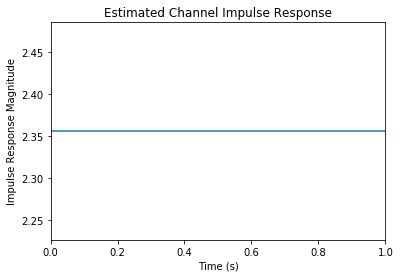

In [122]:
fig, ax = plt.subplots()
plt.title("Estimated Channel Impulse Response")
plt.xlabel("Time (s)")
plt.ylabel("Impulse Response Magnitude")
ax.plot(x, y)
plt.xlim(0, 1)
plt.show()


In [72]:
from sklearn.linear_model import LinearRegression
def pilot_calculate_phase_gains(received_signal, N, L_pilot):
    n_pilot = N // L_pilot 
    # there are L pilot tones
    DFT_received_signal = compute_average_symbol(received_signal)
    phase_gains_pilot_symbols = np.array([])
    x_components = np.array([])
    x_component = math.pi * 2 / N 
    
    for index in QPSK_indices:
        if index % n_pilot == 0:
            phase = QPSK_indices[index]/(A*pilot_value) 
            phase = np.angle(phase)
            phase_gains_pilot_symbols = np.append(phase_gains_pilot_symbols, phase) # setting a known pilot value on the pilot_place 
            x_components = np.append(x_components, x_component*index)
    return x_components, phase_gains_pilot_symbols


def pilot_calculate_delay(received_signal, N, L_pilot):
    n_pilot = N//L_pilot 
    X, y = pilot_calculate_phase_gains(received_signal, N, L_pilot)
    reg = LinearRegression().fit(X, y)
    return reg.coef_
    
    

# Shift the received array left by the amount of the delay. (A certain number of elements) Also cut the array where we expect the transmitted sequency to end.
def calculate_received_signal_without_delay(received_signal, chirp_signal):
    """Takes the received signal and the chirp, to remove the delay and perform synchronisation"""
    delay = calculate_delay_at_receiver(received_signal, chirp_signal) # Calculate delay

    chirp_length = len(chirp_signal) # Find length of chirp signal
    received_signal_without_delay = received_signal[delay+chirp_length:delay+chirp_length+(n*(N+L))] # Using calculated delay, remove the delay

    return received_signal_without_delay

In [73]:
x_comp, phase = pilot_calculate_phase_gains(received_signal, N, L)

ValueError: array split does not result in an equal division

In [ ]:
print(pilot_calculate_delay(received_signal, N, L))

In [ ]:
def estimate_channel_RX_signal_pilot_tones(received_signal):
    
    chirp_signal = generateChirp(100, 15000, sample_rate, chirp_duration)
    received_signal_without_delay = calculate_received_signal_without_delay_pilot_tones(received_signal, chirp_signal) # Perform synchronisation by removing time delay

    # (In frequency domain)
    OFDM_RX_demod_average = compute_average_symbol(received_signal_without_delay) # Compute the average demodulated OFDM sequence
    H_est = estimate_channel_frequency_response(OFDM_RX_demod_average, generate_random_sequence(N)) # Be careful that random sequence is the same from earlier

    # (In time domain)
    h_time = compute_channel_impulse_response(H_est) #
    return h_time, H_est

In [ ]:
h_time, H_est = estimate_channel_RX_signal(output_signal)

In [ ]:
print(len(h_time))
print(len(channel_response))

In [148]:
from scipy import signal
sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))
corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

In [150]:
print(sig.shape)
print(corr.shape)

(1024,)
(1024,)
